# Chapter 9. Back to the Feature: Building an Academic Paper Recommender

* Open Academic Society: [Project Page](https://www.openacademic.ai/oag/) : Downloads > MAG Papers > mag_papers_0.zip 다운로드

* Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

## 9장에서 사용할 데이터 생성

In [1]:
import pandas as pd

In [2]:
model_df = pd.read_json('data/mag_papers/mag_papers_0.txt', lines=True) # 100만
model_df.shape

(1000000, 19)

In [3]:
# 2만 건의 데이터만 예제에서 사용

df20000 = model_df.iloc[:20000,:]
df20000.shape

(20000, 19)

In [4]:
df20000.to_json('data/mag_papers/mag_subset20K.txt', orient='records', lines=True)

## Example 9-1. Import + filter data

In [5]:
model_df = pd.read_json('data/mag_papers/mag_subset20K.txt', lines=True)
model_df.shape

(20000, 19)

In [6]:
model_df.columns

Index(['abstract', 'authors', 'doc_type', 'doi', 'fos', 'id', 'issue',
       'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher',
       'references', 'title', 'url', 'venue', 'volume', 'year'],
      dtype='object')

In [7]:
# 영어가 아닌 논문은 제외.
# 제목이 중복인 것 제외
model_df = model_df[model_df.lang == 'en'].drop_duplicates(subset = 'title', keep = 'first')

# abstract, authors, fos, keywords, year, title 컬럼만 사용
model_df = model_df.drop(['doc_type', 
                          'doi', 'id', 
                          'issue', 'lang', 
                          'n_citation', 
                          'page_end', 
                          'page_start', 
                          'publisher', 
                          'references',
                          'url', 
                          'venue', 
                          'volume'], axis=1)

In [8]:
# 최종적으로 약 1만개의 논문만 사용한다.
model_df.shape

(10399, 6)

In [9]:
model_df.head(2)

,abstract,authors,fos,keywords,title,year
0,A system and method for maskless direct write ...,None,"[Electronic engineering, Computer hardware, En...",None,System and Method for Maskless Direct Write Li...,2015
1,None,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",The dilemma of the Mycobacterium avium subspec...,2016


## Example 9-2. Collaborative filtering stage 1: Build item feature matrix

In [10]:
from sys import getsizeof
import random

In [11]:
# 연구분야
unique_fos = sorted(list({feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

# 출간년도
unique_year = sorted(model_df['year'].astype('str').unique())

print('unique_fos  :', len(unique_fos))
print('unique_year :', len(unique_year))
print('total       :', len(unique_fos + unique_year))

unique_fos  : 7604
unique_year : 156
total       : 7760


In [12]:
# 연구분야가 null이 아닌 데이터 수
model_df.shape[0] - pd.isnull(model_df['fos']).sum()

8666

In [13]:
[unique_fos[i] for i in sorted(random.sample(range(len(unique_fos)), 15)) ]

['Anesthesia',
 'Antigen-presenting cell',
 'Bioinformatics',
 'Concerted evolution',
 'Concurrent constraint logic programming',
 'Fire',
 'Glyceraldehyde 3-phosphate dehydrogenase',
 'IEEE 802.11s',
 'Inverter',
 'Java annotation',
 'Laguerre polynomials',
 'Length scale',
 'Magnetic field',
 'Natural language processing',
 'Point source']

In [14]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

In [15]:
%time year_features = feature_array(model_df['year'], unique_year)

Wall time: 23.4 s


In [16]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

print('Size of fos feature array: ', getsizeof(fos_features))

Wall time: 23min 30s
Size of fos feature array:  4902670968


In [17]:
print(year_features.shape)
print(fos_features.shape)

(10399, 156)
(10399, 7604)


In [18]:
year_features.shape[1] + fos_features.shape[1]

7760

In [19]:
# 10399 x 7760 array
%time first_features = fos_features.join(year_features).T

first_size = getsizeof(first_features)
print('Size of first feature array: ', first_size)

Wall time: 5.87 s
Size of first feature array:  5003741538


In [20]:
first_features.shape

(7760, 10399)

In [21]:
first_features.head()

,0,1,2,5,7,8,9,10,11,12,...,19985,19986,19987,19988,19993,19994,19995,19997,19998,19999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-10 V lighting control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3 protein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Example 9-3. Collaborative filtering stage 2: Search for similar items

In [22]:
from scipy.spatial.distance import cosine

In [23]:
def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(index = features_df.columns, columns = features_df.columns)
    
    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] = 1 - cosine(features_df[i].astype('float'), features_df[j].astype('float'))
    
    return item_similarities

In [24]:
%time first_items = item_collab_filter(first_features.loc[:, 0:1000])

Wall time: 10min 21s


## Example 9-4. Heatmap of paper recommendations

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

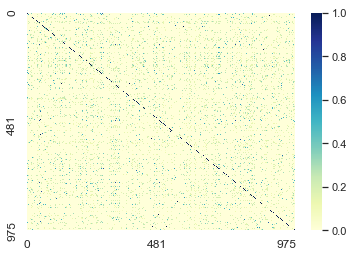

In [26]:
# 그림 9-3
sns.set()
ax = sns.heatmap(first_items.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap="YlGnBu", 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

## Example 9-5. Item-based collaborative filtering recommendations

In [27]:
def paper_recommender(paper_index, items_df):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = items_df.loc[paper_index].sort_values(ascending=False).head(4)
    print('\nTop three results: ') 
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [28]:
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                 None
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                      None
keywords                                                 None
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  2
Similarity score:  1.0
abstract                                                 None
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                      None
keywords                                                 None
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object 

2 . Paper index =  292
Similarity score:  1.0
abstract                                                 None
aut

## Example 9-6. Fixed-width binning + dummy coding (part 1)

In [29]:
model_df['year'].tail()

19994    1951
19995    2017
19997    1971
19998    1986
19999    2015
Name: year, dtype: int64

In [30]:
print("Year spread: ", model_df['year'].min()," - ", model_df['year'].max())
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Year spread:  1831  -  2017
Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


Text(0,0.5,'Occurrence')

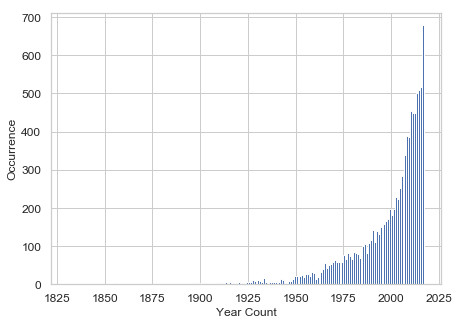

In [31]:
# 그림 9-5. year의 분포 확인
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
model_df['year'].hist(ax=ax, bins= model_df['year'].max() - model_df['year'].min())
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

## Example 9-7. Fixed-width binning + dummy coding (part 2)

In [32]:
# bin은 데이터의 수가 아니라 변수의 범위를 기준으로 설정한다.
model_df['year'].max() - model_df['year'].min()

186

In [33]:
# year 피쳐를 10년 단위로 비닝
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

In [34]:
# year 피쳐를 10년 단위로 비닝함으로써 피쳐 공간을 156에서 19로 줄인다.
print('We have reduced from', len(model_df['year'].unique()),
      'to', len(temp_df['yearBinned'].values.unique()), 'features representing the year.')

We have reduced from 156 to 19 features representing the year.


In [35]:
X_yrs = pd.get_dummies(temp_df['yearBinned'])
X_yrs.head()

,"(1831.0, 1841.0]","(1841.0, 1851.0]","(1851.0, 1860.0]","(1860.0, 1870.0]","(1870.0, 1880.0]","(1880.0, 1890.0]","(1890.0, 1900.0]","(1900.0, 1909.0]","(1909.0, 1919.0]","(1919.0, 1929.0]","(1929.0, 1939.0]","(1939.0, 1948.0]","(1948.0, 1958.0]","(1958.0, 1968.0]","(1968.0, 1978.0]","(1978.0, 1988.0]","(1988.0, 1997.0]","(1997.0, 2007.0]","(2007.0, 2017.0]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [36]:
X_yrs.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]]
              closed='right',
              dtype='interval[float64]')

Text(0,0.5,'Counts')

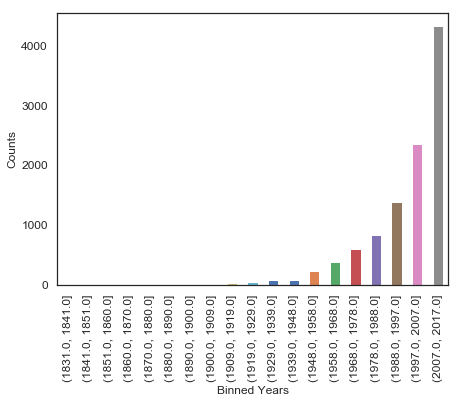

In [37]:
# 그림 9-6. 비닝한 year의 분포 확인
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7, 5))
X_yrs.sum().plot.bar(ax = ax)
ax.tick_params(labelsize=12)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

## Example 9-8. Converting bag-of-phrases pd.Series to NumPy sparse array

In [38]:
X_fos = fos_features.values

In [39]:
# 각 객체의 크기를 보면 나중에 어떤 차이를 만들게 될지 예상할 수 있다.
print('Our pandas Series, in bytes: ', getsizeof(fos_features))
print('Our hashed numpy array, in bytes: ', getsizeof(X_fos))

Our pandas Series, in bytes:  4902998648
Our hashed numpy array, in bytes:  112


## Example 9-9. Collaborative filtering stages 1 + 2: Build item feature matrix, search for similar items

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

In [41]:
X_yrs.shape[1] + X_fos.shape[1]

7623

In [42]:
# 10399 x 7623 array

%time second_features = np.append(X_fos, X_yrs, axis = 1)

second_size = getsizeof(second_features)
print('Size of second feature array, in bytes: ', second_size)

Wall time: 259 ms
Size of second feature array, in bytes:  634172728


In [43]:
print("The power of feature engineering saves us, in bytes: ", getsizeof(fos_features) - second_size)

The power of feature engineering saves us, in bytes:  4268825920


In [44]:
def piped_collab_filter(features_matrix, index, top_n):
                
    item_similarities = 1 - cosine_similarity(features_matrix[index:index+1], features_matrix).flatten() 
    related_indices = [i for i in item_similarities.argsort()[::-1] if i != index]

    return [(index, item_similarities[index]) for index in related_indices][0:top_n]

## Example 9-10. Item-based collaborative filtering recommendations: Take 2

In [45]:
def paper_recommender(items_df, paper_index, top_n):
    if paper_index in model_df.index:
        
        print('Based on the paper:')
        print('Paper index = ', model_df.loc[paper_index].name)
        print('Title :', model_df.loc[paper_index]['title'])
        print('FOS :', model_df.loc[paper_index]['fos'])
        print('Year :', model_df.loc[paper_index]['year'])
        print('Abstract :', model_df.loc[paper_index]['abstract'])
        print('Authors :', model_df.loc[paper_index]['authors'], '\n')
        
        # 요청된 DataFrame 인덱스에 대한 위치 인덱스 정의
        array_ix = model_df.index.get_loc(paper_index)

        top_results = piped_collab_filter(items_df, array_ix, top_n)
        
        print('\nTop',top_n,'results: ') 
        
        order = 1
        for i in range(len(top_results)):
            print(order,'. Paper index = ', model_df.iloc[top_results[i][0]].name)
            print('Similarity score: ', top_results[i][1])
            print('Title :', model_df.iloc[top_results[i][0]]['title'])
            print('FOS :', model_df.iloc[top_results[i][0]]['fos'])
            print('Year :', model_df.iloc[top_results[i][0]]['year'])
            print('Abstract :', model_df.iloc[top_results[i][0]]['abstract'])
            print('Authors :', model_df.iloc[top_results[i][0]]['authors'], '\n')
            if order < top_n: order += 1
    
    else:
        print('Whoops! Choose another paper. Try something from here: \n', model_df.index[100:200])

In [46]:
paper_recommender(second_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : None
Year : 2015
Abstract : None
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : None
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  11771
Similarity score:  1.0
Title : A Study of Special Functions in the Theory of

## Example 9-11. Maintaining index assignment during conversions

In [47]:
model_df.loc[21]

abstract    A microprocessor includes hardware registers t...
authors                      [{'name': 'Mark John Ebersole'}]
fos         [Embedded system, Parallel computing, Computer...
keywords                                                 None
title       Microprocessor that enables ARM ISA program to...
year                                                     2013
Name: 21, dtype: object

In [48]:
model_df.iloc[21]

abstract                                                 None
authors     [{'name': 'Nicola M. Heller'}, {'name': 'Steph...
fos         [Biology, Medicine, Post-transcriptional regul...
keywords    [glucocorticoids, post transcriptional regulat...
title       Post-transcriptional regulation of eotaxin by ...
year                                                     2002
Name: 30, dtype: object

In [49]:
model_df.index.get_loc(30)

21

## Example 9-12. Stopwords + tf-idf

In [50]:
# sklearn을 사용하기 위해 NaN 항목을 채워준다.
filled_df = model_df.fillna('None')

In [51]:
filled_df['abstract'].head()

0    A system and method for maskless direct write ...
1                                                 None
2                                                 None
5                                                 None
7    Full textFull text is available as a scanned c...
Name: abstract, dtype: object

In [52]:
# abstract: 불용어, 빈도기반 필터링
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_abstract = vectorizer.fit_transform(filled_df['abstract'])

X_abstract

<10399x48516 sparse matrix of type '<class 'numpy.float64'>'
	with 374055 stored elements in Compressed Sparse Row format>

In [53]:
print("n_samples: %d, n_features: %d" % X_abstract.shape)

n_samples: 10399, n_features: 48516


In [54]:
X_yrs.shape[1] + X_fos.shape[1] + X_abstract.shape[1]

56139

In [55]:
# 10399 x 56139 array

%time third_features = np.append(second_features, X_abstract.toarray(), axis = 1)

Wall time: 11 s


In [56]:
paper_recommender(third_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : None
Year : 2015
Abstract : None
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : None
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  11773
Similarity score:  1.0
Title : Studies of powder flow using a recording powd

## Example 9-13. One-hot encoding using scikit-learn’s DictVectorizer

In [57]:
authors_df = pd.DataFrame(filled_df.authors)
authors_df.head()

,authors
0,None
1,[{'name': 'Ahmed M. Alluwaimi'}]
2,"[{'name': 'Jovana P. Lekovich', 'org': 'Weill ..."
5,[{'name': 'George C. Sponsler'}]
7,[{'name': 'M. T. Richards'}]


In [58]:
authors_list = []

for row in authors_df.itertuples():
    # 각 시리즈 인덱스로부터 딕셔너리 생성 
    if type(row.authors) is str:
        y = {'None': row.Index}
    if type(row.authors) is list:
        # 이 키와 값을 딕셔너리에 추가
        y = dict.fromkeys(row.authors[0].values(), row.Index)
    authors_list.append(y)

In [59]:
authors_list[0:5]

[{'None': 0},
 {'Ahmed M. Alluwaimi': 1},
 {'Jovana P. Lekovich': 2, 'Weill Cornell Medical College, New York, NY': 2},
 {'George C. Sponsler': 5},
 {'M. T. Richards': 7}]

In [60]:
v = DictVectorizer(sparse=False)
D = authors_list
X_authors = v.fit_transform(D)

X_authors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
print("n_samples: %d, n_features: %d" % X_authors.shape)

n_samples: 10399, n_features: 14028


In [62]:
X_yrs.shape[1] + X_fos.shape[1] + X_abstract.shape[1] + X_authors.shape[1]

70167

In [63]:
# 10399 x 70167 array

%time fourth_features = np.append(third_features, X_authors, axis = 1)

Wall time: 7.52 s


## Example 9-14. Item-based collaborative filtering recommendations: Take 3

In [64]:
paper_recommender(fourth_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : None
Year : 2015
Abstract : None
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : None
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  5601
Similarity score:  1.0
Title : 633 Survival after coronary revascularization,